In [1]:
import pandas as pd
import numpy as np
import nltk
import huggingface_hub
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('omw-1.4')
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()
from bertopic import BERTopic
from umap import UMAP
import re as re
import os 
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from umap import UMAP

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/silvinhad/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/silvinhad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('/Users/silvinhad/Desktop/bertopic Python Analysis/veramagalhaes_tweets.csv').astype("string")
data = data.dropna(subset=["text"])
data.head(3)

,id,author_id,text,edit_history_tweet_ids,possibly_sensitive,in_reply_to_user_id,created_at,referenced_tweets,conversation_id,lang,retweet_count,reply_count,like_count,quote_count
0,1586870139936464897,1558969867126149127,RT @joaofilippe12: Hoje é o dia em que Mirian ...,<NA>,False,<NA>,2022-10-30T23:58:18.000Z,<NA>,1586870139936464897,pt,1,0,0,0
1,1586870122764967937,1523457948399423488,RT @DaniMYGonzalez: Vera Magalhães bate boca c...,<NA>,False,<NA>,2022-10-30T23:58:14.000Z,<NA>,1586870122764967937,pt,359,0,0,0
2,1586869839230025728,1574540960608014345,RT @saritacoelho: A imprensa inteira que se so...,<NA>,False,<NA>,2022-10-30T23:57:06.000Z,<NA>,1586869839230025728,pt,2407,0,0,0


In [3]:
data_sample = data.sample(n=30000, random_state=42).reset_index(drop=True)

In [4]:
import re as re
import unicodedata as unicodedata
def basic_clean(string):
    '''
    This function takes in a string and
    returns the string normalized.
    '''
    string = str(string)
    string = string.lower()
    string = re.sub(r'#[A-Za-z0-9]*', ' ', string)
    string = re.sub(r'@[A-Za-z0-9]+', ' ', string)
    string = re.sub(r'[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~“…”’'), ' ', string)
    string = re.sub(r'\d+', ' ', string)
    string = re.sub(r'\n+', ' ', string)
    string = re.sub(r"http\S+", "", string)   # URLs
    string = re.sub(r"@\w+", "", string)      # mentions
    string = re.sub(r"\s+", " ", string)
    string = unicodedata.normalize('NFKD', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
    string = re.sub(r'[^\w\s]', '', string).lower()
    return string

data_sample['basic_clean'] = data_sample.text.apply(basic_clean).astype("string")
data_sample['basic_clean']

0        rt o sr deveria no minimo ter a decencia e a c...
1                  rt vera magalhaes pau mandada do doria 
2        rt sentiu vera magalhaes assustada com a quant...
3        rt sobre o ataque do dep douglas garcia a jorn...
4        rt por que o felipe neto vera magalhaes pachec...
                               ...                        
29995                       essa vera magalhaes e ridicula
29996    rt prezada vera magalhaes satisfacao em reve l...
29997    rt vera magalhaes mentiu sobre bolsonaro tomou...
29998    rt vera magalhaes deu um presente pro bolsonar...
29999    rt enquanto a direita discute inutilmente sobr...
Name: basic_clean, Length: 30000, dtype: string

In [5]:
def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()

    # Use tokenizer
    string = tokenizer.tokenize(string, return_str = True)

    return string

data_sample['tokenize'] = data_sample.basic_clean.apply(tokenize).astype("string")
data_sample['tokenize']

0        rt o sr deveria no minimo ter a decencia e a c...
1                   rt vera magalhaes pau mandada do doria
2        rt sentiu vera magalhaes assustada com a quant...
3        rt sobre o ataque do dep douglas garcia a jorn...
4        rt por que o felipe neto vera magalhaes pachec...
                               ...                        
29995                       essa vera magalhaes e ridicula
29996    rt prezada vera magalhaes satisfacao em reve l...
29997    rt vera magalhaes mentiu sobre bolsonaro tomou...
29998    rt vera magalhaes deu um presente pro bolsonar...
29999    rt enquanto a direita discute inutilmente sobr...
Name: tokenize, Length: 30000, dtype: string

In [6]:
def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()

    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]

    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)
    
    return string

data_sample['lemmatize'] = data_sample.tokenize.apply(lemmatize).astype("string")
data_sample['lemmatize']

0        rt o sr deveria no minimo ter a decencia e a c...
1                   rt vera magalhaes pau mandada do doria
2        rt sentiu vera magalhaes assustada com a quant...
3        rt sobre o ataque do dep douglas garcia a jorn...
4        rt por que o felipe neto vera magalhaes pachec...
                               ...                        
29995                       essa vera magalhaes e ridicula
29996    rt prezada vera magalhaes satisfacao em reve l...
29997    rt vera magalhaes mentiu sobre bolsonaro tomou...
29998    rt vera magalhaes deu um presente pro bolsonar...
29999    rt enquanto a direita discute inutilmente sobr...
Name: lemmatize, Length: 30000, dtype: string

In [7]:
import pandas as pd

stopwords = pd.read_csv('/Users/silvinhad/Desktop/bertopic Python Analysis/Portuguese_stopwords.csv', header=None) [0].tolist()

print(len(stopwords))   # should be 432
print(stopwords[:10])   # preview

433
['word', '4k3oos92am', 'a', 'à', 'afirma', 'afirmou', 'agora', 'aí', 'ainda', 'além']


In [8]:
def remove_stopwords(string, extra_words = [], exclude_words = []):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords
    
    # Remove 'exclude_words' from stopword_list to keep these in my text.
    stopword_list = set(stopword_list) - set(exclude_words)
    
    # Add in 'extra_words' to stopword_list.
    stopword_list = stopword_list.union(set(extra_words))

    # Split words in string.
    words = string.split()
    
    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]
    
    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)
    
    return string_without_stopwords

data_sample['text_without_stopwords'] = data_sample.lemmatize.apply(remove_stopwords).astype("string")
data_sample['text_without_stopwords']


0        sr deveria minimo decencia coragem bois trocad...
1                         vera magalhaes pau mandada doria
2        sentiu vera magalhaes assustada quantidade gen...
3        ataque dep douglas garcia jornalista vera maga...
4        felipe neto vera magalhaes pacheco simone tebe...
                               ...                        
29995                              vera magalhaes ridicula
29996    prezada vera magalhaes satisfacao reve bolsona...
29997    vera magalhaes mentiu bolsonaro tomou invertid...
29998    vera magalhaes deu presente pro bolsonaro bloc...
29999    direita discute inutilmente vera magalhaes pdt...
Name: text_without_stopwords, Length: 30000, dtype: string

In [9]:
data_sample

,id,author_id,text,edit_history_tweet_ids,possibly_sensitive,in_reply_to_user_id,created_at,referenced_tweets,conversation_id,lang,retweet_count,reply_count,like_count,quote_count,basic_clean,tokenize,lemmatize,text_without_stopwords
0,1570019446890332160,1397956976647315458,"RT @plinioce: O sr. deveria, no mínimo, ter a ...",<NA>,False,<NA>,2022-09-14T11:59:40.000Z,<NA>,1570019446890332160,pt,25,0,0,0,rt o sr deveria no minimo ter a decencia e a c...,rt o sr deveria no minimo ter a decencia e a c...,rt o sr deveria no minimo ter a decencia e a c...,sr deveria minimo decencia coragem bois trocad...
1,1564073826505326593,952577755295703040,"RT @RaquelStasiaki: Vera Magalhães, pau mandad...",<NA>,False,<NA>,2022-08-29T02:13:53.000Z,<NA>,1564073826505326593,pt,142,0,0,0,rt vera magalhaes pau mandada do doria,rt vera magalhaes pau mandada do doria,rt vera magalhaes pau mandada do doria,vera magalhaes pau mandada doria
2,1577380153914793985,1550188505145479172,RT @viniciuscfp82: SENTIU! Vera Magalhães assu...,<NA>,False,<NA>,2022-10-04T19:28:29.000Z,<NA>,1577380153914793985,pt,3764,0,0,0,rt sentiu vera magalhaes assustada com a quant...,rt sentiu vera magalhaes assustada com a quant...,rt sentiu vera magalhaes assustada com a quant...,sentiu vera magalhaes assustada quantidade gen...
3,1570197039111184384,1304580948990873600,RT @marciatiburi: Sobre o ataque do dep. Dougl...,<NA>,False,<NA>,2022-09-14T23:45:21.000Z,<NA>,1570197039111184384,pt,92,0,0,0,rt sobre o ataque do dep douglas garcia a jorn...,rt sobre o ataque do dep douglas garcia a jorn...,rt sobre o ataque do dep douglas garcia a jorn...,ataque dep douglas garcia jornalista vera maga...
4,1568247369975619590,981740708548706304,"RT @kimpaim: Por que o Felipe Neto, Vera Magal...",<NA>,False,<NA>,2022-09-09T14:38:04.000Z,<NA>,1568247369975619590,pt,6931,0,0,0,rt por que o felipe neto vera magalhaes pachec...,rt por que o felipe neto vera magalhaes pachec...,rt por que o felipe neto vera magalhaes pachec...,felipe neto vera magalhaes pacheco simone tebe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1565088586659135493,325741141,@veramagalhaes Essa Vera Magalhães é Ridícula,<NA>,False,19667016.0,2022-08-31T21:26:11.000Z,<NA>,1564715674672529413,pt,0,0,0,0,essa vera magalhaes e ridicula,essa vera magalhaes e ridicula,essa vera magalhaes e ridicula,vera magalhaes ridicula
29996,1581797353618833408,1424870566918557708,"RT @ZAMENZA: ""Prezada Vera Magalhães, satisfaç...",<NA>,False,<NA>,2022-10-17T00:00:52.000Z,<NA>,1581797353618833408,pt,55,0,0,0,rt prezada vera magalhaes satisfacao em reve l...,rt prezada vera magalhaes satisfacao em reve l...,rt prezada vera magalhaes satisfacao em reve l...,prezada vera magalhaes satisfacao reve bolsona...
29997,1564680353595498499,989107371405438976,RT @reportersalles: Vera Magalhães mentiu sobr...,<NA>,False,<NA>,2022-08-30T18:24:01.000Z,<NA>,1564680353595498499,pt,1059,0,0,0,rt vera magalhaes mentiu sobre bolsonaro tomou...,rt vera magalhaes mentiu sobre bolsonaro tomou...,rt vera magalhaes mentiu sobre bolsonaro tomou...,vera magalhaes mentiu bolsonaro tomou invertid...
29998,1564066853219180546,1317540385829363712,RT @arthurmoledoval: Vera Magalhães deu um pre...,<NA>,False,<NA>,2022-08-29T01:46:11.000Z,<NA>,1564066853219180546,pt,112,0,0,0,rt vera magalhaes deu um presente pro bolsonar...,rt vera magalhaes deu um presente pro bolsonar...,rt vera magalhaes deu um presente pro bolsonar...,vera magalhaes deu presente pro bolsonaro bloc...


In [10]:
# exporting the cleaned tweets to generate a wordcloud (part 2)
data_sample.text_without_stopwords.to_csv(r'tweets_sample_veramagalhaes_cleaned.csv', index=False)

In [11]:
import os
import pandas as pd

from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from gensim import corpora
from gensim.models import CoherenceModel

from bertopic import BERTopic
from hdbscan import HDBSCAN

# ------------------------------------------------------------------
# ENV
# ------------------------------------------------------------------
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ------------------------------------------------------------------
# EMBEDDINGS (pt-BR)
# ------------------------------------------------------------------

from transformers import AutoModel, AutoTokenizer

model_name = "neuralmind/bert-base-portuguese-cased"

# Load the tokenizer (handles text conversion)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model (the actual BERT model)
model = AutoModel.from_pretrained(model_name)

embedding_model = SentenceTransformer(
    "neuralmind/bert-base-portuguese-cased"
)

# ------------------------------------------------------------------
# UMAP
# ------------------------------------------------------------------
umap_model = UMAP(
    n_neighbors=15,
    n_components=10,
    metric="cosine",
    low_memory=False,
    random_state=42
)

# ------------------------------------------------------------------
# VECTORIZER (n-grams)
# ------------------------------------------------------------------
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),
    min_df=5
)

# ------------------------------------------------------------------
# BERTopic
# ------------------------------------------------------------------
hdbscan_model = HDBSCAN(
    min_cluster_size=30,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    embedding_model=embedding_model,
    nr_topics=60,
    calculate_probabilities=True,
    verbose=True
)

# ------------------------------------------------------------------
# FIT MODEL
# ------------------------------------------------------------------
docs = data_sample["text_without_stopwords"].tolist()
topics, _ = topic_model.fit_transform(docs)

# ------------------------------------------------------------------
# GROUP DOCUMENTS PER TOPIC (REMOVE OUTLIERS)
# ------------------------------------------------------------------
### WE NEED TO ADD THE NUMBER OF TWEETS PER TOPIC HERE!!!

documents = pd.DataFrame({
    "Document": docs,
    "Topic": topics
})

documents = documents[documents.Topic != -1]

documents_per_topic = (
    documents
    .groupby("Topic", as_index=False)
    .agg(
        tweets_count=("Document", "count"),
        Document=("Document", " ".join)
    )
)

No sentence-transformers model found with name neuralmind/bert-base-portuguese-cased. Creating a new one with MEAN pooling.
2026-01-12 21:26:57,311 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

2026-01-12 21:29:09,334 - BERTopic - Embedding - Completed ✓
2026-01-12 21:29:09,334 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2026-01-12 21:30:06,132 - BERTopic - Dimensionality - Completed ✓
2026-01-12 21:30:06,133 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-12 21:36:47,160 - BERTopic - Cluster - Completed ✓
2026-01-12 21:36:47,164 - BERTopic - Representation - Extracting topics from clusters using representation models.
2026-01-12 21:36:47,686 - BERTopic - Representation - Completed ✓
2026-01-12 21:36:47,686 - BERTopic - Topic reduction - Reducing number of topics
2026-01-12 21:36:48,163 - BERTopic - Topic reduction - Reduced number of topics from 407 to 60


In [12]:
# exporting document and topics
documents.to_csv(r'topics_tweets_veramagalhaes.csv',index=False)
documents_per_topic.to_csv(r'topics_grouped_veramagalhaes.csv', index=False)

In [13]:
documents_per_topic

,Topic,tweets_count,Document
0,0,10813,sr deveria minimo decencia coragem bois trocad...
1,1,3131,ciro metendo meio ataque bolsonaro vera magalh...
2,2,971,invertida vera magalhaes pergunta visando atin...
3,3,479,candidato repudiar agressao mesmo classificou ...
4,4,414,ca senador t parre cantanhede tentando chorar ...
5,5,402,globo apos debate bolsonaro cancela sabatina j...
6,6,378,questionei vera magalhaes contrato tv cultura ...
7,7,363,menos mulheres brasileiras rejeitam bolsonaro ...
8,8,323,vera magalhaes serum lembra t tzglmikewe rasgo...
9,9,285,erro grave debate negar direito resposta chama...


In [14]:

# ------------------------------------------------------------------
# TOKENIZATION (ALIGNED WITH VECTORIZER)
# ------------------------------------------------------------------
analyzer = vectorizer_model.build_analyzer()

tokens = [
    analyzer(doc)
    for doc in documents_per_topic.Document
]

# ------------------------------------------------------------------
# GENSIM STRUCTURES
# ------------------------------------------------------------------
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

# ------------------------------------------------------------------
# EXTRACT & FILTER TOPIC WORDS (CRITICAL FIX)
# ------------------------------------------------------------------
topic_words = []

for topic in documents_per_topic.Topic:
    words = topic_model.get_topic(topic)
    if words is None:
        continue

    # keep only tokens known by gensim dictionary
    valid_words = [
        word for word, _ in words
        if word in dictionary.token2id
    ]

    # coherence requires at least 2 words
    if len(valid_words) >= 2:
        topic_words.append(valid_words)

# ------------------------------------------------------------------
# SAFETY CHECKS
# ------------------------------------------------------------------
assert len(topic_words) > 0, "No valid topics for coherence"
assert len(topic_words) <= len(tokens), "Topics/texts misalignment"

# ------------------------------------------------------------------
# COHERENCE
# ------------------------------------------------------------------
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=tokens,
    corpus=corpus,
    dictionary=dictionary,
    coherence="c_v"
)

coherence = coherence_model.get_coherence()

print(f"Topic coherence (c_v): {coherence:.4f}")

Topic coherence (c_v): 0.5580


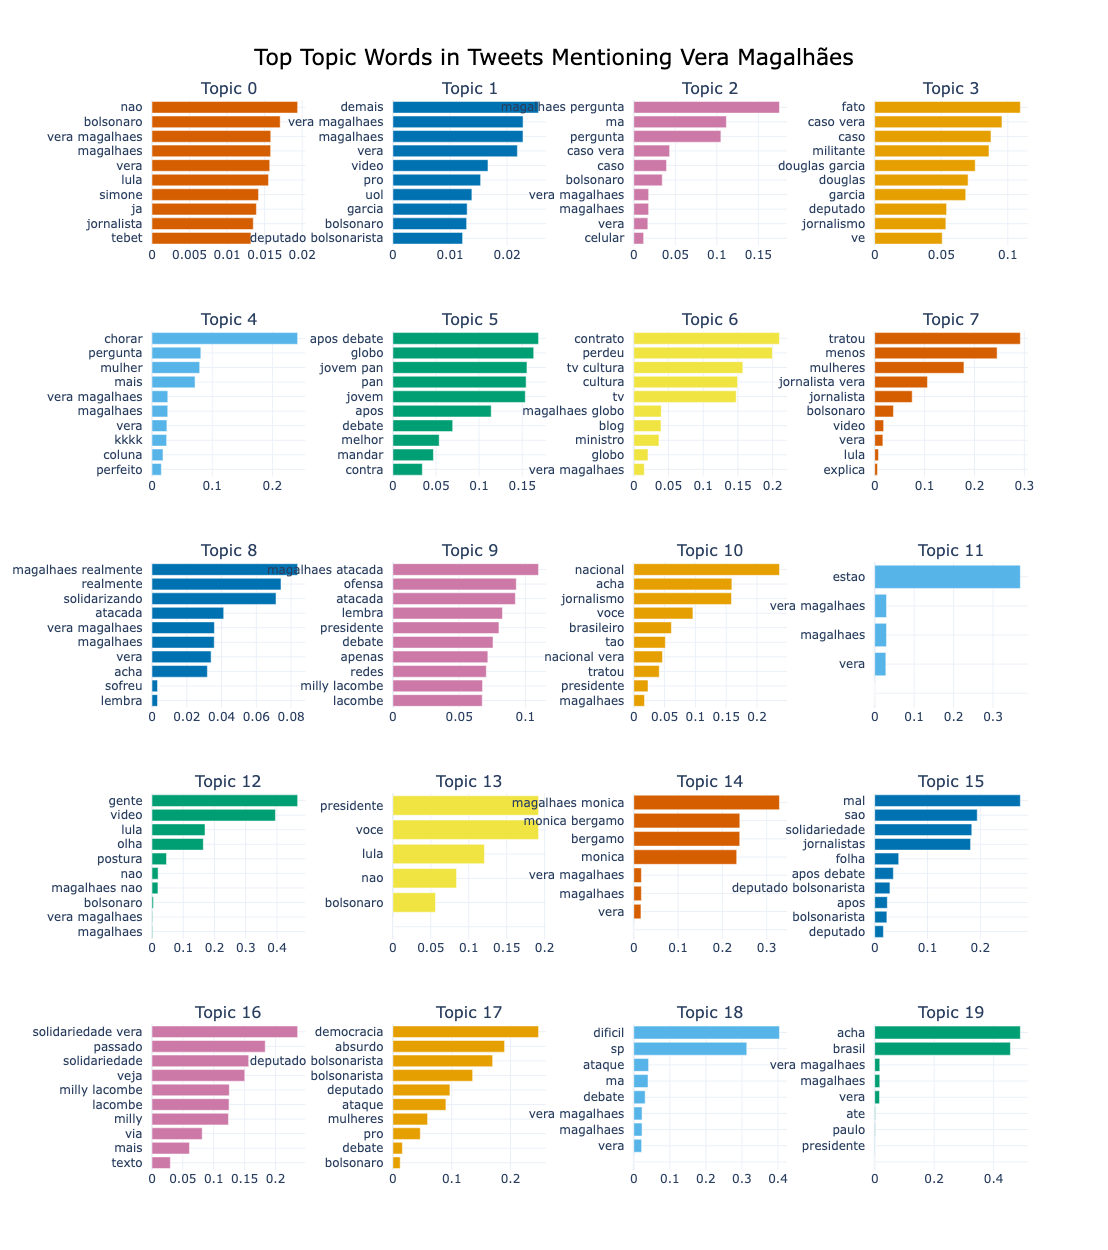

In [15]:
fig = topic_model.visualize_barchart(top_n_topics=20, n_words=10)

fig.update_layout(
    title_text="Top Topic Words in Tweets Mentioning Vera Magalhães"
)

fig.show()

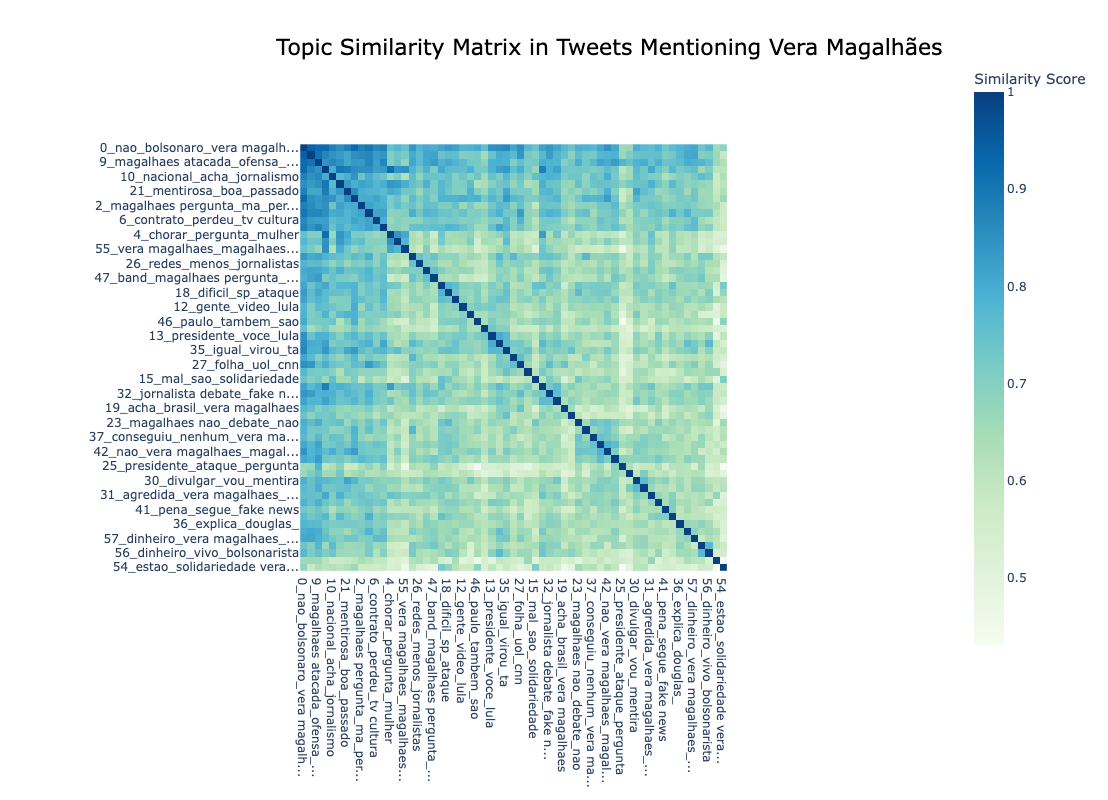

In [16]:
fig2 = topic_model.visualize_heatmap(n_clusters=20)

fig2.update_layout(
    title_text="Topic Similarity Matrix in Tweets Mentioning Vera Magalhães"
)

fig2.show()


In [17]:
documents

,Document,Topic
0,sr deveria minimo decencia coragem bois trocad...,0
1,vera magalhaes pau mandada doria,0
2,sentiu vera magalhaes assustada quantidade gen...,0
3,ataque dep douglas garcia jornalista vera maga...,0
4,felipe neto vera magalhaes pacheco simone tebe...,0
...,...,...
29991,milly lacombe prestar solidariedade vera magal...,16
29992,rio grande sul ha ditado cachorro come ovelha ...,0
29993,ana paula henkel colocou vera magalhaes devido...,1
29997,vera magalhaes mentiu bolsonaro tomou invertid...,0


In [18]:
import openai
from bertopic.representation import OpenAI
import os
os.environ["OPENAI_API_KEY"] = "ADD YOUR OPENAI KEY HERE" 

client = openai.OpenAI(api_key=os.environ["OPENAI_API_KEY"])

topic_model.update_topics(
    docs,
    topics=topics,
    representation_model=OpenAI(
        client,
        model="gpt-4o-mini",
        delay_in_seconds=5
    )
)
topic_model.get_topic_info()


2026-01-12 21:36:58,053 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
100%|███████████████████████████████████████████| 60/60 [05:39<00:00,  5.66s/it]


,Topic,Count,Name,Representation,Representative_Docs
0,-1,7563,-1_Political attacks on journalists,[Political attacks on journalists],[solidariedade jornalista vera magalhaes ofend...
1,0,10813,0_Brazilian political discourse on social media,[Brazilian political discourse on social media],[bolsonaro atacava vera magalhaes ciro gargalh...
2,1,3131,1_Social media discussion on Brazilian politics,[Social media discussion on Brazilian politics],[vera magalhaes carinho chega manipular fatos ...
3,2,971,2_Political criticism of Bolsonaro,[Political criticism of Bolsonaro],[invertida vera magalhaes pergunta visando ati...
4,3,479,3_Brazilian journalism and political discourse,[Brazilian journalism and political discourse],[vera magalhaes x douglas garcia questionament...
5,4,414,4_Texto confuso em português,[Texto confuso em português],[cantanhede tentando chorar mais alto vera mag...
6,5,402,5_Media coverage of political events in Brazil,[Media coverage of political events in Brazil],[globo apos debate bolsonaro cancela sabatina ...
7,6,378,6_Controversial incident at a TV event,[Controversial incident at a TV event],[questionei vera magalhaes contrato tv cultura...
8,7,363,7_Rejection of Bolsonaro by Brazilian women,[Rejection of Bolsonaro by Brazilian women],[menos mulheres brasileiras rejeitam bolsonaro...
9,8,323,8_Unintelligible or nonsensical text,[Unintelligible or nonsensical text],[solidarizando vera magalhaes realmente acha a...


In [19]:
topic_info = topic_model.get_topic_info()

final_topics = topic_info.merge(
    documents_per_topic[["Topic", "tweets_count"]],
    on="Topic",
    how="left"
)

final_topics.to_csv(
    "bertopic_topics_openai_veramagalhaes.csv",
    index=False,
    encoding="utf-8"
)

In [20]:
import scipy.cluster.hierarchy as sch

linkage_function = lambda x: sch.linkage(
    x,
    method="single",
    optimal_ordering=True
)

hierarchical_topics = topic_model.hierarchical_topics(
    docs,
    linkage_function=linkage_function
)


100%|███████████████████████████████████████████| 58/58 [05:28<00:00,  5.66s/it]


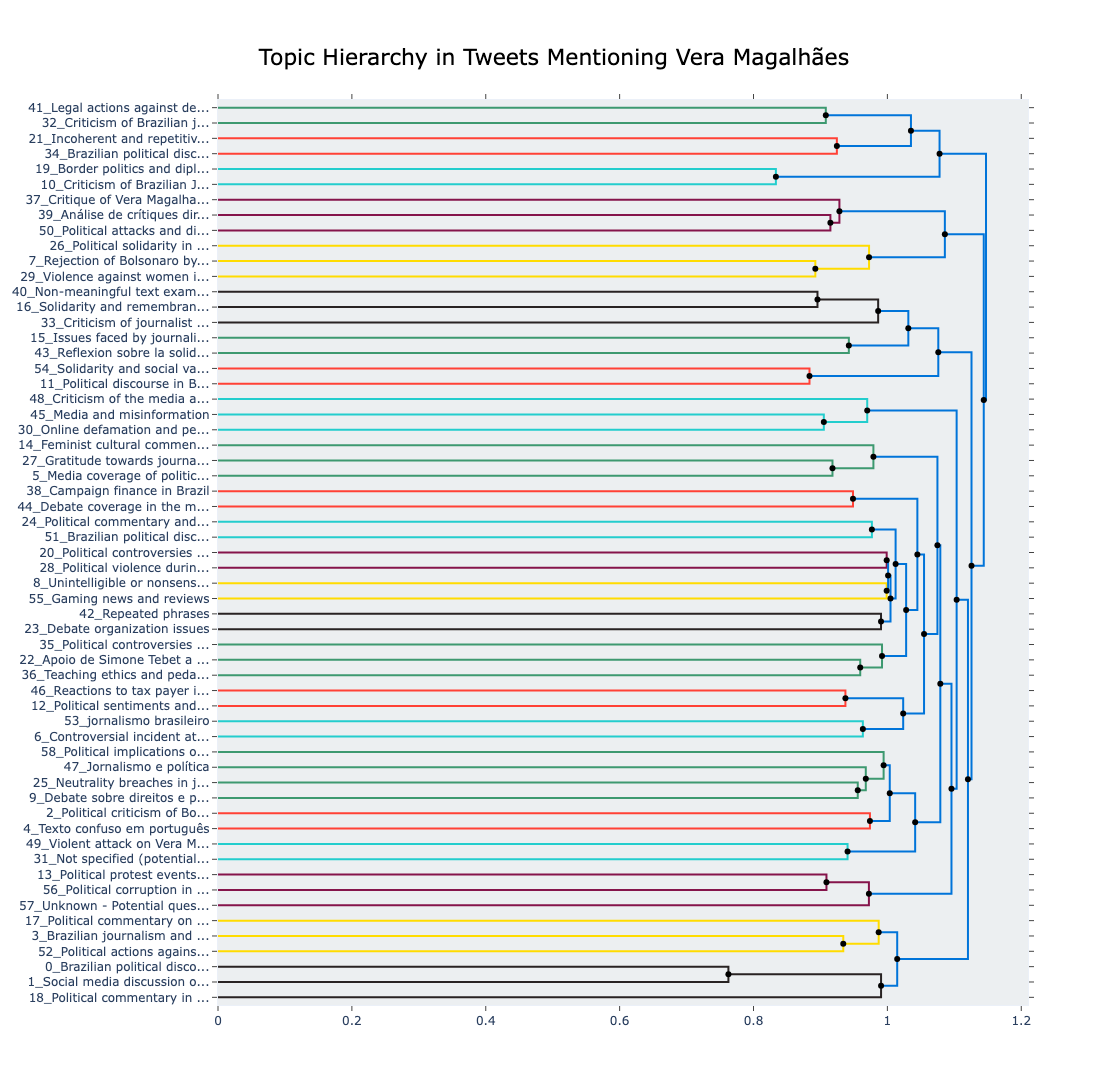

In [21]:
fig3 = topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics
)

fig3.update_layout(
    title_text="Topic Hierarchy in Tweets Mentioning Vera Magalhães"
)

fig3.show()


In [22]:
hierarchical_topics.to_csv(
    "hierarchical_topics_veramagalhaes.csv",
    index=False
)
